In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import savemat
import json
import os
import re

from LoadTargets import LoadTargets
from BehavCleanUp import BehavCleanUp
from NEW_BehavPreProc import NEW_BehavPreProc

In [2]:
def convert_np_arrays_to_lists(data):
    if isinstance(data, dict):
        return {k: convert_np_arrays_to_lists(v) for k, v in data.items()}
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

In [3]:
# Initialize parameters used in the analysis

PARAM = {}

PARAM['pix2cm'] = 5.4135
PARAM['vel_thresh_cmsec'] = 2
PARAM['lap_min_boundary'] = 25
PARAM['lap_max_boundary'] = 110

PARAM['nSDsm_pos'] = 0.01
PARAM['nSDsm_vel'] = 2.5

PARAM['t_min_sec'] = 3
PARAM['max_ret'] = 0.1
PARAM['max_vel_cmsec'] = 40
# PARAM['nvt_fname_in'] = 'VT1_fixed.nvt'
PARAM['nvt_fname_in'] = 'nvt_data.json'
PARAM['bhv_fname_out'] = ''

PARAM['bhv_cx'] = 0
PARAM['bhv_cy'] = 0
PARAM['bhv_hsz_x'] = 0
PARAM['bhv_hsz_y'] = 0

PARAM['plf_num_colors'] = 64
PARAM['plf_thr_type'] = 'perPFR'
PARAM['plf_thr_perPFR'] = 20
PARAM['ds_thr'] = 10
PARAM['sgolayfilt_k'] = 3
PARAM['sgolayfilt_f'] = 31
PARAM['interp1_method'] = 'nearest'

# Load dataset list from file
dset_list = LoadTargets('trials_tmaze.txt')

# nSD_frmap_smth = 3
# bin_sz_cm = 2
# dsp_delay = 984

# s_fname_bhv = 'bhv2.mat'
# s_fname_suff_plf = '_plf.mat'
# s_fname_csv = 'Shuo_linear_track_plf.csv'

# lcnt = 1
# list_out = cell(1,1)


Process dataset: /Users/huangjuhua/NYU/MatlabFramework_SampleCode_Data/Tmaze_Data/252-1375/2018-01-07_15-14-54/04_tmaze1


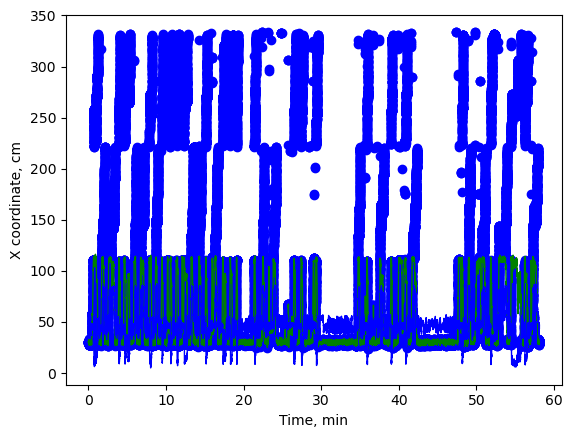

In [4]:
for dataset in dset_list:
    print(f'Process dataset: {dataset}')

    # Extract parts of the dataset path
    s_trial, _ = os.path.splitext(dataset)
    s_dataset, _ = os.path.splitext(s_trial)
    s_mouse, _ = os.path.splitext(s_dataset)
    
    tmp = dataset
    
    s1 = tmp.replace('/', '_').replace('\\', '_')[3:]
#     s2 = f'{tmp}_laps.jpg'
#     s3 = f'{tmp}_velocity_omitted_laps.jpg'
    
    trg1 = os.path.join(tmp, PARAM['nvt_fname_in'])
    
    #  Load and process positional data from neuralynx files
    with open(trg1, 'r') as file:
        data = json.load(file)
    
    _, Xpos1, Ypos1 = BehavCleanUp(data['TSusec'], data['Xpos1'], data['Ypos1'], PARAM);
    BEHAV = NEW_BehavPreProc(data['TSusec'], data['Xpos1'], data['Ypos1'], data['Ang1'], PARAM['nSDsm_pos'], PARAM['nSDsm_vel']);
    
    # Transform coordinates to a new system
    xx = BEHAV['pos_x_cm']
    yy = BEHAV['pos_y_cm']
    zz = np.zeros_like(xx)  # Initialize zz with the same shape and type as xx

    for i in range(len(xx)):
        if 43.5 <= yy[i] <= 49:
            if xx[i] < 111:
                zz[i] = xx[i]
            else:
                zz[i] = 111
        elif yy[i] > 49:
            if xx[i] >= 108:
                zz[i] = yy[i] - 49 + 111
            elif 34 <= xx[i] < 108:
                zz[i] = 111 + 81 - 49 + np.sqrt((81 - yy[i])**2 + (xx[i] - 108)**2)
            else:
                zz[i] = xx[i]
        elif yy[i] < 43.5:
            if xx[i] >= 108:
                zz[i] = -yy[i] + 43.5 + 221.5
            elif 34 <= xx[i] < 108:
                zz[i] = 43.5 - 11.5 + np.sqrt((yy[i] - 11.5)**2 + (xx[i] - 108)**2) + 221.5
            else:
                zz[i] = xx[i]
                


    # Temporary variables for data handling and plotting.
    zz1 = []
    tz1 = []
    vz1 = []
    tt = BEHAV['pos_ts_usec'].T
    vv = BEHAV['vel_cmsec'].T

    BEHAV['pos_ts_usec_z'] = tt
    BEHAV['pos_z_cm'] = zz
    BEHAV['vel_cmsec_z'] = vv

    BEHAV['outline_Z'] = [np.min(BEHAV['pos_z_cm']), np.max(BEHAV['pos_z_cm'])]
    BEHAV['outline_legend_Z'] = ['Zmin', 'Zmax']

    # Initialize and configure the figure for displaying processed data.
    plt.figure('Figure Visible')
    ax = plt.subplot(1, 1, 1)

    # Plot the processed position and velocity data.
    ax.plot((BEHAV['pos_ts_usec'] - BEHAV['pos_ts_usec'][0]) / (1e6 * 60), BEHAV['pos_x_cm'], 'g', linewidth=1)
    ax.plot((BEHAV['pos_ts_usec'] - BEHAV['pos_ts_usec'][0]) / (1e6 * 60), BEHAV['pos_y_cm'], 'b', linewidth=1)
    ax.scatter((BEHAV['pos_ts_usec_z'] - BEHAV['pos_ts_usec'][0]) / (1e6 * 60), BEHAV['pos_z_cm'], color='b')

    ax.set_xlim([0, 5])

    # Label axes and save the figure to file.
    ax.set_xlabel('Time, min')
    ax.set_ylabel('X coordinate, cm')
    ax.axis('tight')
    pic_name = os.path.join(tmp, f"{s1}_linearized.jpg")
    plt.savefig(pic_name, format='jpeg', dpi=600)

    BEHAV['pos_x_cm'] = BEHAV['pos_z_cm'].T
    BEHAV['pos_y_cm'] = np.ones(BEHAV['pos_x_cm'].shape)
    BEHAV['outline'] = [BEHAV['outline_Z'][0], BEHAV['outline_Z'][1], 1, 1]

    BEHAV['vel_cmsec'] = BEHAV['vel_cmsec_z'].T
    BEHAV['pos_ts_usec'] = BEHAV['pos_ts_usec_z'].T

    # Calculate center coordinates and half-sizes for behavioral data based on outlines.
    PARAM['bhv_cx'] = BEHAV['outline_Z'][0] + (BEHAV['outline_Z'][1] - BEHAV['outline_Z'][0]) / 2
    PARAM['bhv_cy'] = BEHAV['outline'][2] + (BEHAV['outline'][3] - BEHAV['outline'][2]) / 2
    PARAM['bhv_hsz_x'] = (BEHAV['outline_Z'][1] - BEHAV['outline_Z'][0]) / 2
    PARAM['bhv_hsz_y'] = (BEHAV['outline'][3] - BEHAV['outline'][2]) / 2

    # Save the final processed behavior data and parameters.
    PARAM['bhv_fname_out'] = os.path.join(tmp, 'bhv_linearized.json')
    
    bhv_data_to_save = convert_np_arrays_to_lists({'PARAM': PARAM, 'BEHAV': BEHAV})
    with open(PARAM['bhv_fname_out'], 'w') as f:
        json.dump(bhv_data_to_save, f, indent=4)

    num_rows = len(BEHAV['pos_ts_usec_z'])
    num_columns = 7  # Adjust the number of columns as needed

    Position_Data = np.zeros((num_rows, num_columns))  # Initialize with zeros

    # Now you can assign values to Position_Data
    Position_Data[:, 0] = BEHAV['pos_ts_usec_z'] / 1e6
    Position_Data[:, 1] = BEHAV['pos_x_cm']
    Position_Data[:, 2] = BEHAV['pos_y_cm']
    Position_Data[:, 3] = 0  # Assuming you need this column initialized to zeros

    # Assuming NEW_BehavPreProc is a function you have the Python equivalent for:
    TMP_BEHAV = NEW_BehavPreProc(Position_Data[:, 0] * 1e6, Position_Data[:, 1], Position_Data[:, 2], BEHAV['head_angles'], PARAM['nSDsm_pos'], PARAM['nSDsm_vel'])
    Position_Data[:, 4] = TMP_BEHAV['vel_cmsec']

    Position_Data[:, 5] = 0
    Position_Data[1:, 6] = np.diff(Position_Data[:, 0])
    Position_Data[0, 6] = Position_Data[1, 6]
    Position_Data[Position_Data[:, 6] > 60, 6] = 0

    # Save the processed position data.
    position_data_to_save = {'Position_Data': Position_Data.tolist()}
    
    with open(os.path.join(tmp, 'Position_Data_Processed.json'), 'w') as f:
        json.dump(position_data_to_save, f, indent=4)

Feature Names: ['TSusec', 'Xpos1', 'Ypos1', 'Ang1']